In [1]:
import pickle
import networkit as nk
import networkx as nx
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import multiprocessing as mp
import re
from scipy import stats
from functools import partial
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr
from scipy.optimize import curve_fit
import psutil
import datetime as dt
import glob
import joblib
from tqdm import tqdm


### Description

In this notebook we compute network centrality measures, focusing in particular on the 0.01% most retweeted users for each super-community.

In [2]:
sys.path.insert(1,'../helpers')
import destino

In [3]:
#Load raw data and keeps one row for each user
col_names=['created_at','id','user.id','user.screen_name',
           'user.num_followers','lang']
len(col_names)

def read_data(f_name):
    """Reads single parquet file"""
    return pd.read_parquet(f_name,columns=col_names)

def load_threads(f_names):
    """Load data with threads"""
    ts = time.time()
    parallel = joblib.Parallel(n_jobs=30, prefer='threads')
    read_data_delayed = joblib.delayed(read_data)
    res = parallel(read_data_delayed(f_name) for f_name in tqdm(f_names))
    df = pd.concat(res)
    te = time.time()
    print(f'Load threads took {te-ts:.5f} sec')
    return df

directory='data/parq/tweets'
lst=os.listdir(directory)
lst.sort()
s_t=time.time()

lst_path=[directory+'/'+fi for fi in lst]
df=load_threads(lst_path)
df=df[df['lang']=='en']
df.drop(['lang'],axis=1,inplace=True)
print(df.shape)

df.drop_duplicates(subset=['user.id'],keep='last',inplace=True)
print(df.shape)
e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))

100%|██████████| 2734/2734 [03:19<00:00, 13.72it/s] 


Load threads took 481.41362 sec
(353993900, 5)
(27565780, 5)
Elapsed time: 14.659415411949158 min


In [4]:
#Maps communities and clustering scores to user dataframe
s_t=time.time()
alphab=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q',
        'R','S','T','U','V','W','X','Y','Z','AA','AB','AC','AD','AE','AF','AG']
com_of_user,how_many_best=destino.load_communities('data/com_of_user_letters_1_30.pickle',c_ids=False)
print('Mapping communities...')
df['community']=df['user.id'].map(com_of_user)

map_score=False
if map_score:
    print('Mapping scores...')
    with open('data/u2cscore_1_30.pickle','rb') as f:
        u2cscore=pickle.load(f)
    df['cscore']=df['user.id'].map(u2cscore)
    df['cscore']=df['cscore']/50
e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))

Mapping communities...
Elapsed time: 1.3239212512969971 min


In [5]:
df.columns

Index(['created_at', 'id', 'user.id', 'user.screen_name', 'user.num_followers',
       'community', 'cscore'],
      dtype='object')

In [22]:
df_score = pd.DataFrame(df.groupby('community')['cscore'].mean())
df_score.reset_index(inplace=True)
df_score['std']=df.groupby('community')['cscore'].std().values
df_score=df_score.loc[df_score['community'].isin(alphab[:15])]

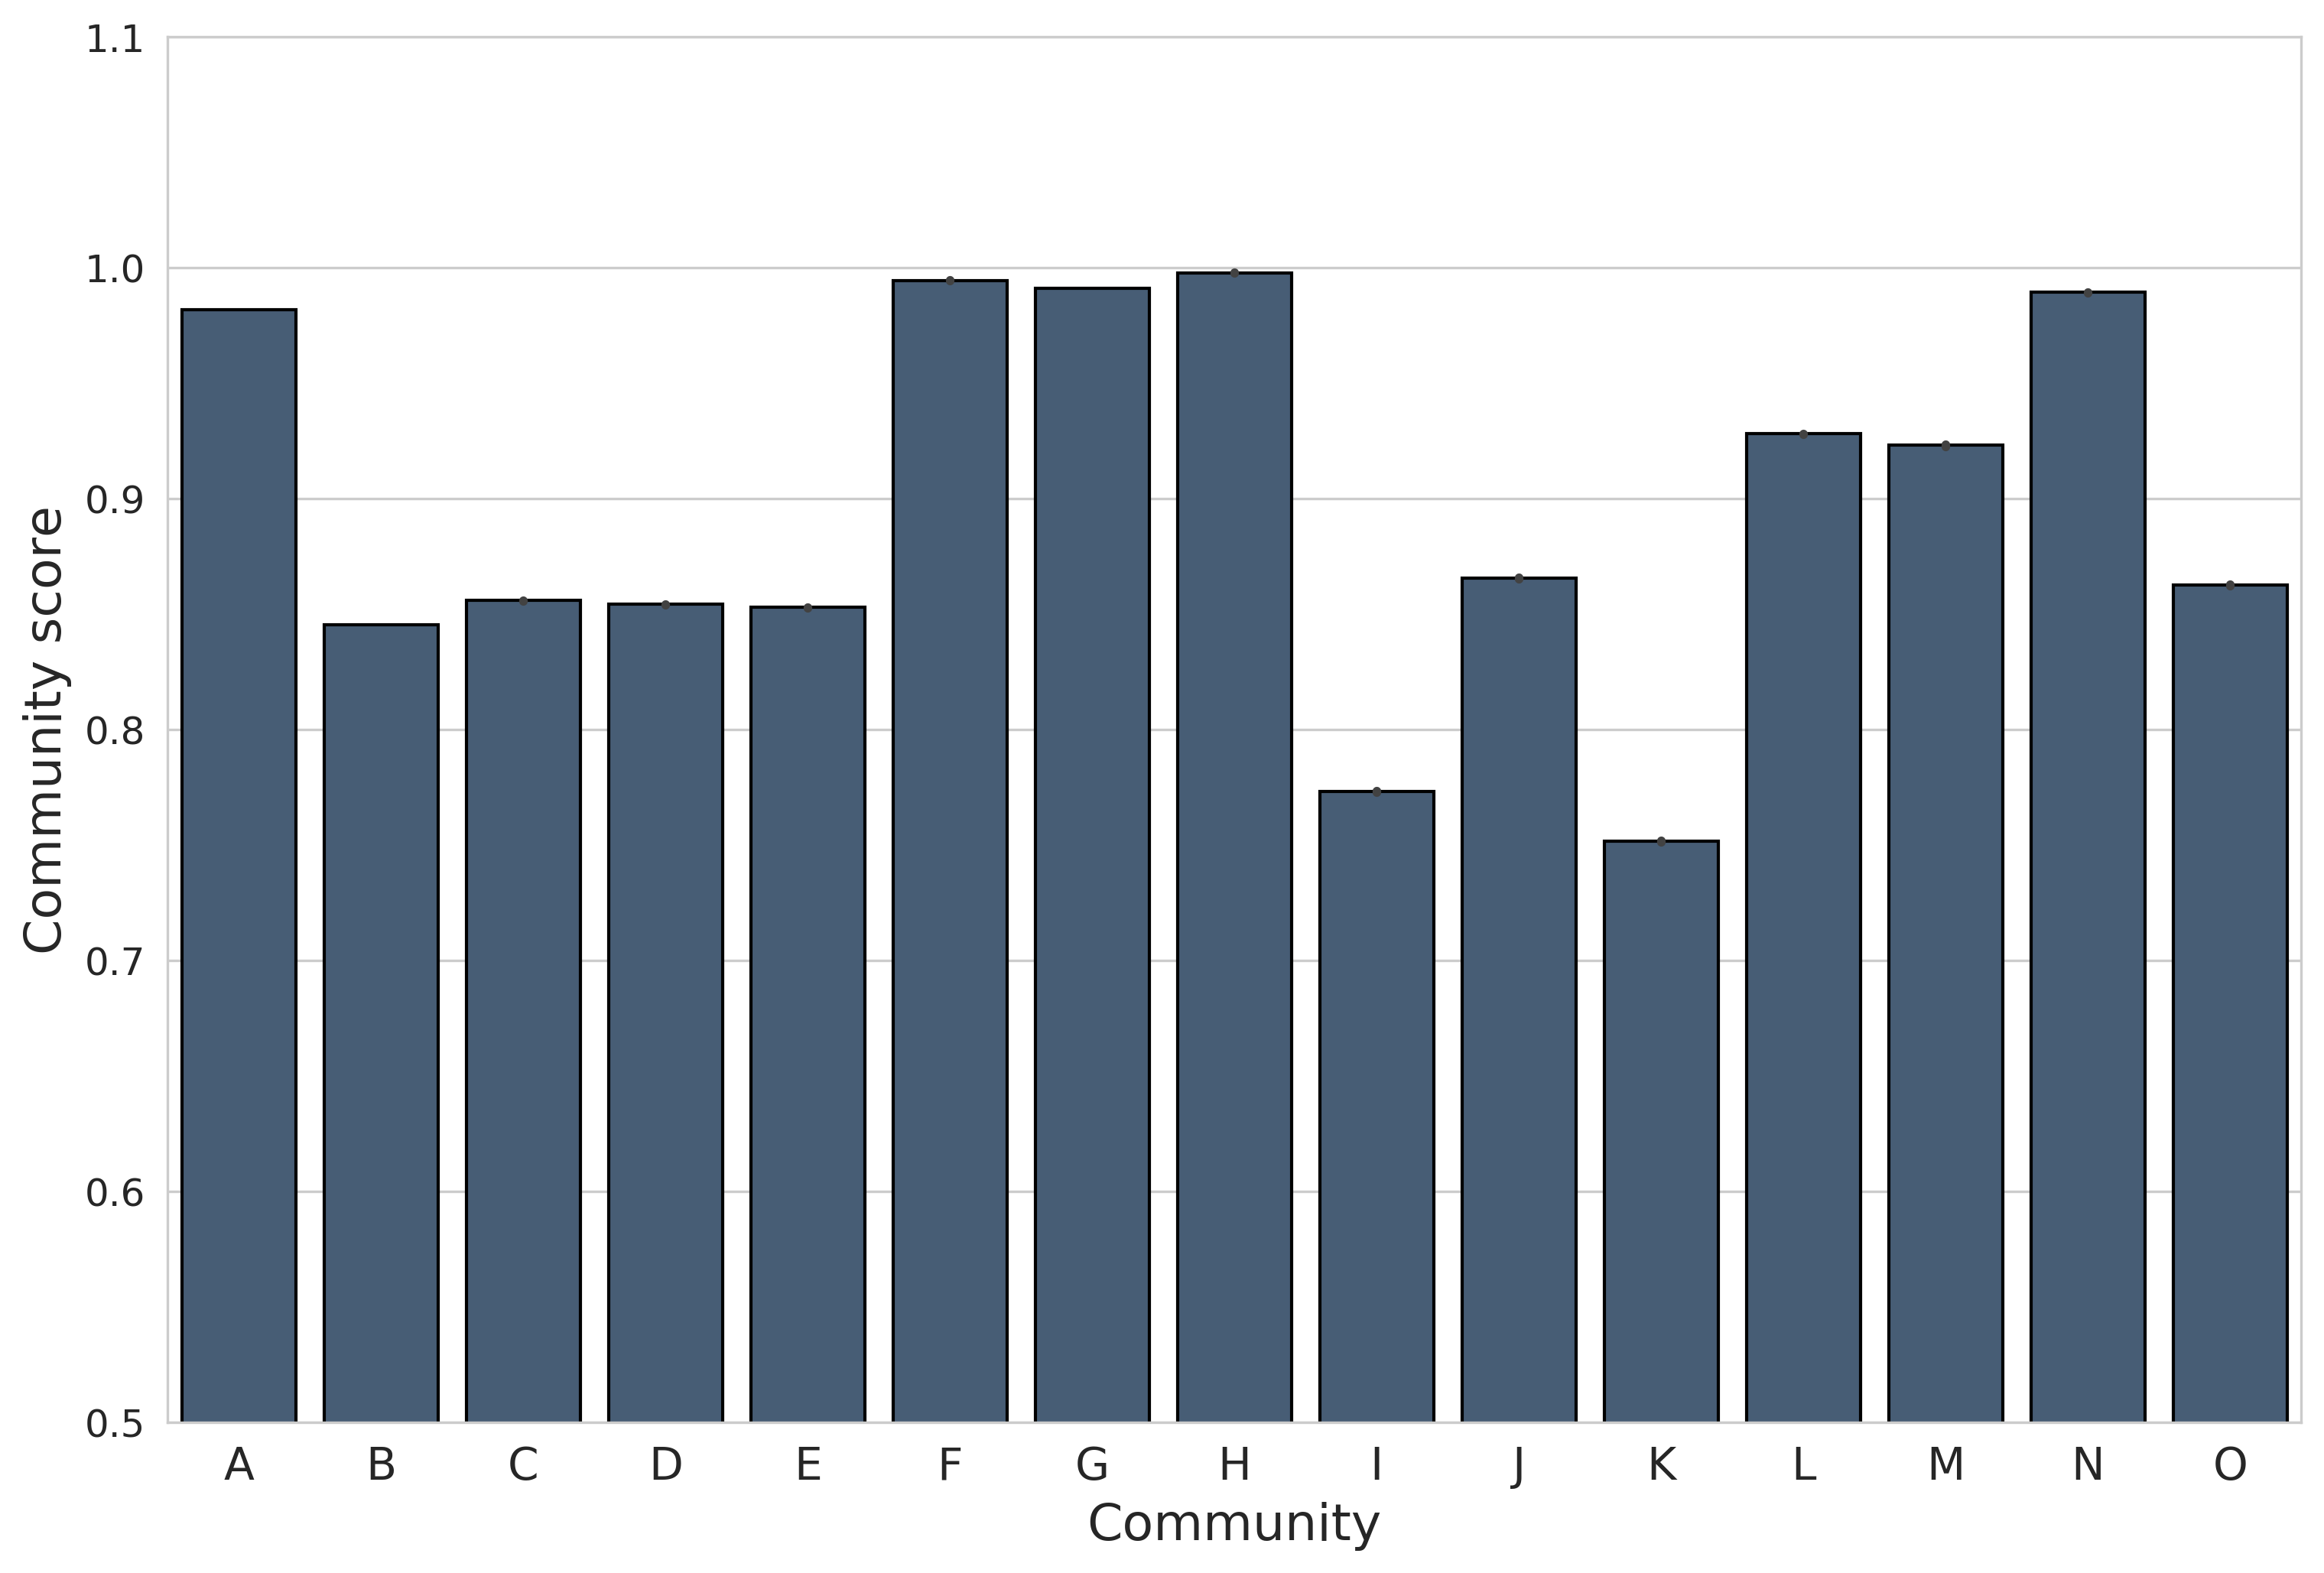

In [16]:
#Average clustering score for users in the network (NOT SHOWN IN PAPER)
f,ax=plt.subplots(1,1,dpi=300,figsize=(12,8))
sns.barplot(x='community', y='cscore', 
            data=df.loc[df['community'].isin(alphab[:15])],
            estimator=np.mean,order=alphab[:15],
           color='#3F5D7D',edgecolor='black',ax=ax);
plt.ylabel('Community score',fontsize=16)
plt.xlabel('Community',fontsize=16)
plt.ylim(.5,1.1)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=12)

### Directed

In [7]:
#Load directed network for all centrality measures except clustering coefficient
#DIRECTED
s_t=time.time()
reader = nk.graphio.EdgeListReader('\t',0, directed=True,continuous=False)
G= reader.read('data/edgelist_may.txt')
print(G.numberOfNodes(), G.numberOfEdges())
id2node=reader.getNodeMap()
#user_set=set(id2node.keys()).intersection(set(df['user.id']))
#print('Users in network and in US: ',len(user_set))
#G=G.subgraphFromNodes([id2node[u] for u in user_set])
cc = nk.components.WeaklyConnectedComponents(G)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component sizes: ", list(cc.getComponentSizes().values())[:10])
Gcon=G.subgraphFromNodes(cc.getComponents()[0])
print(Gcon.numberOfNodes(), Gcon.numberOfEdges())

node2id= {v: k for k, v in id2node.items()}
user_set=set([node2id[v] for v in Gcon.nodes()])
#excluded_users=set(df['user.id'])-user_set
node_set=set(Gcon.nodes())
e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))

22872198 176545735
Users in network and in US:  22872198


/home/PERSONALE/francesco.durazzi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Graph.subgraphFromNodes is deprecated, use graphtools.subgraphFromNodes instead.
  if __name__ == '__main__':


number of components  184623
map of component sizes:  [22512752, 2, 3, 2, 2, 2, 1, 2, 1, 2]


/home/PERSONALE/francesco.durazzi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Graph.subgraphFromNodes is deprecated, use graphtools.subgraphFromNodes instead.
  


22512752 176320516


/home/PERSONALE/francesco.durazzi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Graph.nodes is deprecated.


Elapsed time: 16.45608762105306 min


/home/PERSONALE/francesco.durazzi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Graph.nodes is deprecated.


In [9]:
#Computing in- and out-degree of the nodes
s_t=time.time()
indegree={n:Gcon.weightedDegreeIn(n) for n in node_set}
outdegree={n:Gcon.weightedDegree(n) for n in node_set}
with open('data/dir_indegree.pickle','wb') as f:
    pickle.dump(indegree,f)
with open('data/dir_outdegree.pickle','wb') as f:
    pickle.dump(outdegree,f)
e_t=time.time()-s_t
print('Elapsed time: {} sec'.format(e_t))

Elapsed time: 19.233903169631958 sec


In [10]:
#Compute eigenvector centrality of the nodes
s_t=time.time()
eigencent=dict(nk.centrality.EigenvectorCentrality(Gcon).run().ranking())
with open('data/dir_eigencent.pickle','wb') as f:
    pickle.dump(eigencent,f)
e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))

Elapsed time: 1.722032407919566 min


In [ ]:
#Estimate betweenness centrality of the nodes
s_t=time.time()
betweenness=dict(nk.centrality.EstimateBetweenness(Gcon,100000,normalized=False,
                                              parallel=True).run().ranking())
e_t=time.time()-s_t
print('Elapsed time: {} hours'.format(e_t/60/60))
#1.40 hours for 25k
#6.88 hours 100k

### Approximation goodness for node betweenness centrality

In [120]:
ets=[]
mse=[]
nedges=[]
ns=[2500,5000,10000,15000,20000,30000]
for n in ns:
    Grand=nk.generators.BarabasiAlbertGenerator(8,n).generate()
    print(Grand.numberOfNodes(), Grand.numberOfEdges())
    print('<k>= ',Grand.numberOfEdges()/Grand.numberOfNodes())
    nedges.append(Grand.numberOfEdges())
    s_t=time.time()
    betweenness=dict(nk.centrality.EstimateBetweenness(Grand,n/1000,normalized=False,
                                              parallel=True).run().ranking())
    e_t=time.time()-s_t
    print('Elapsed time: {} mins\n'.format(e_t/60))
    bet_re=dict(nk.centrality.Betweenness(Grand,normalized=False).run().ranking())
    mse.append(np.mean([np.abs(bet_re[i]-betweenness[i])/bet_re[i] for i in range(n)]))
    ets.append(e_t)


2500 19944
<k>=  7.9776
Elapsed time: 0.0003955562909444173 mins

5000 39944
<k>=  7.9888
Elapsed time: 0.0001674056053161621 mins

10000 79944
<k>=  7.9944
Elapsed time: 0.0003406405448913574 mins

15000 119944
<k>=  7.996266666666667
Elapsed time: 0.0005543112754821777 mins

20000 159944
<k>=  7.9972
Elapsed time: 0.0009407440821329753 mins

30000 239944
<k>=  7.9981333333333335
Elapsed time: 0.0016649802525838216 mins



/home/PERSONALE/francesco.durazzi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/PERSONALE/francesco.durazzi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in true_divide


[ 0.31228205 39.04941132]


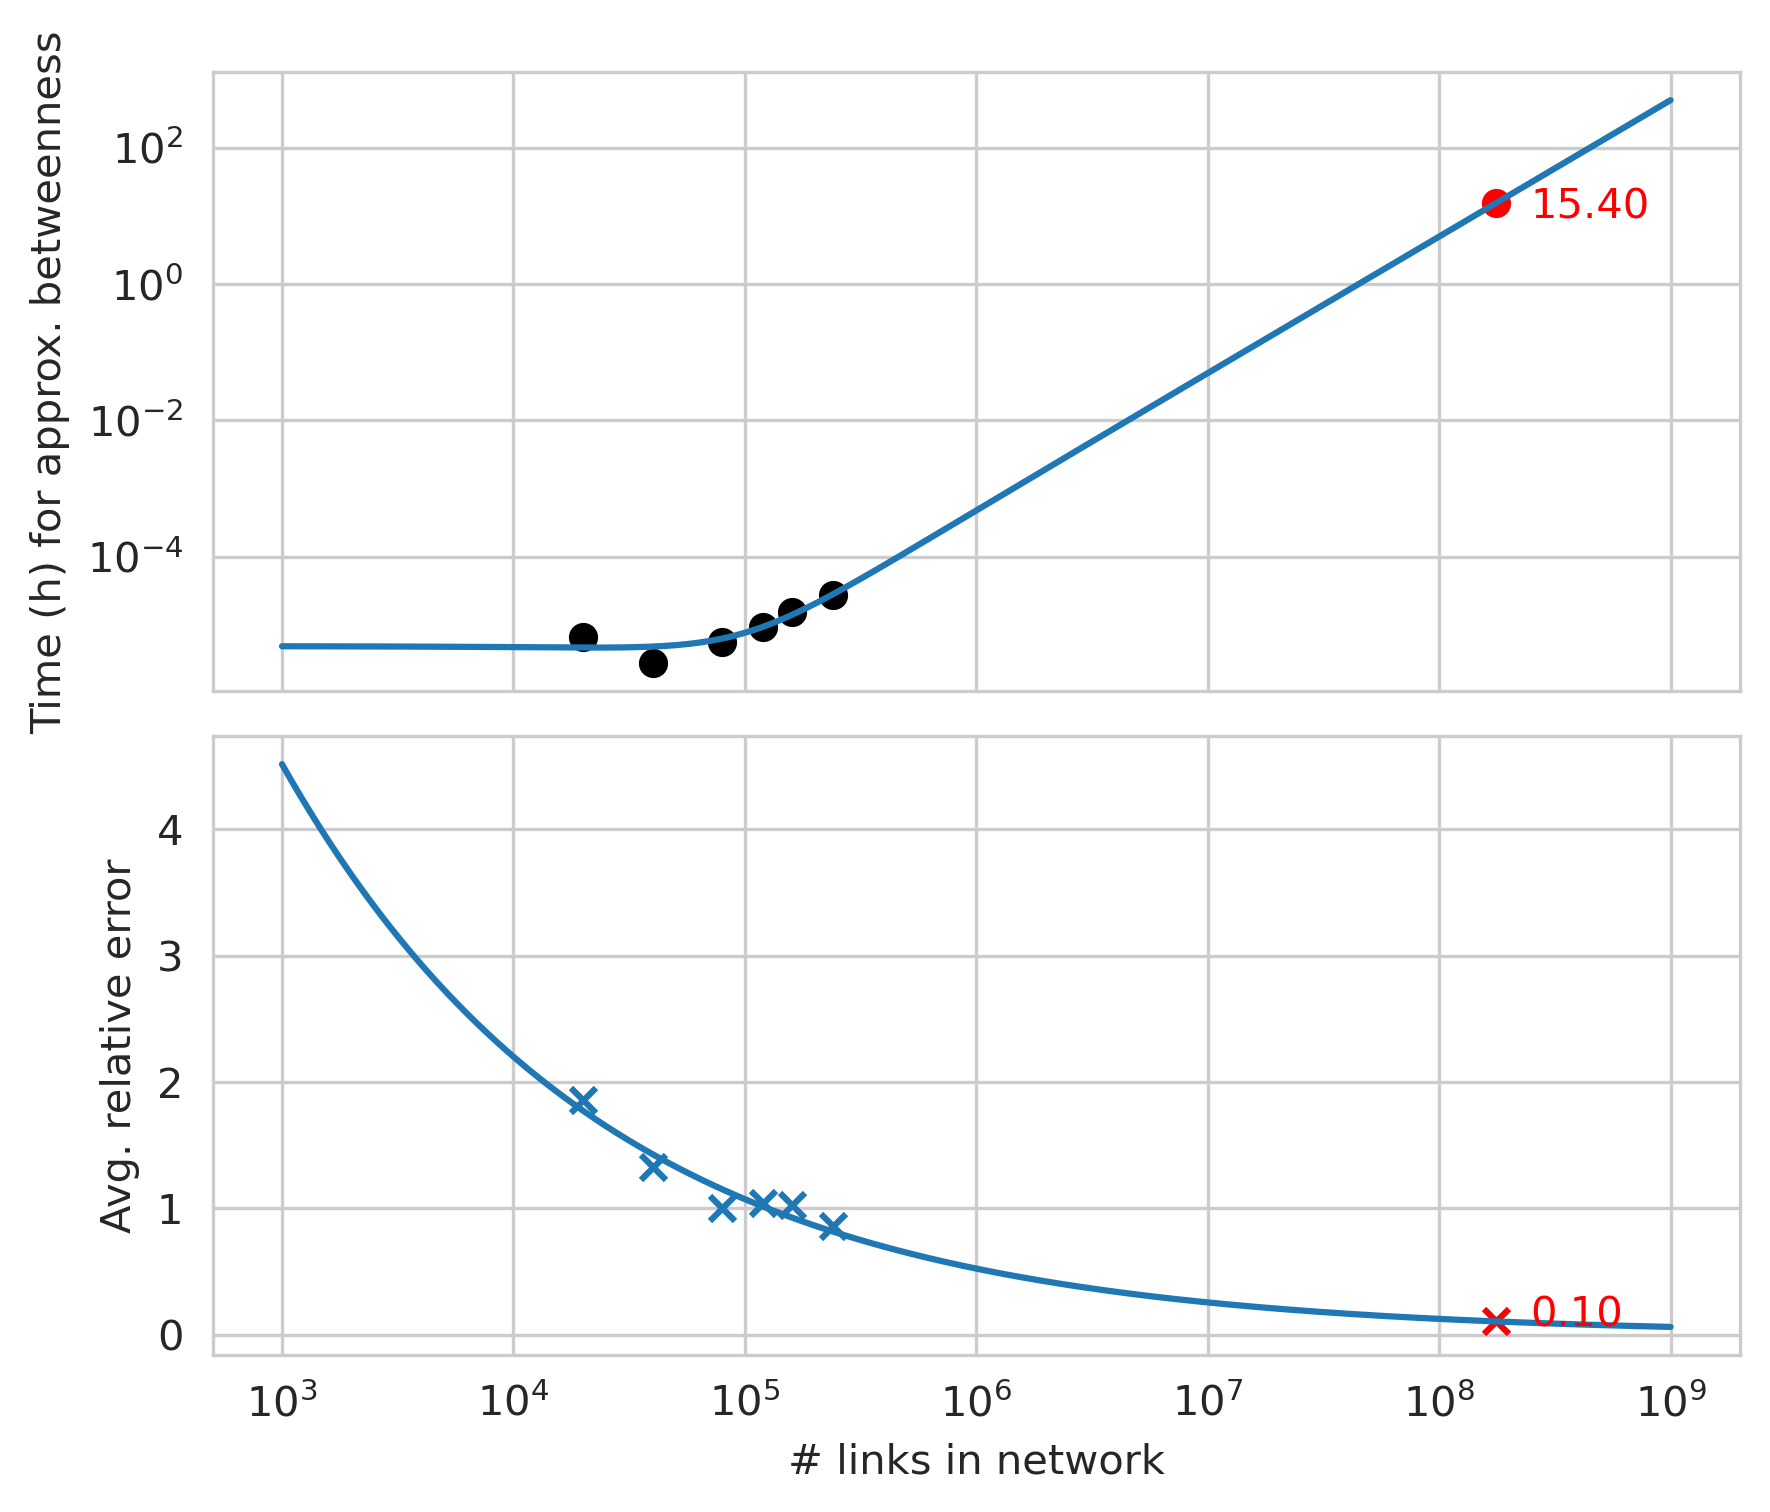

In [122]:
#Red points is the estimation for the 100K as in the paper
times=[t/60/60 for t in ets]
nedges=np.array(nedges).ravel()
z = np.polyfit(nedges, times, 2)
ns_pred=np.array(np.logspace(3,9,1000))
y_pred = np.polyval(z, ns_pred)
y_val=np.polyval(z,176320516)

f,axs=plt.subplots(2,1,dpi=300,sharex=True,figsize=(6,5))
axs[0].scatter(nedges,times,color='black')
axs[0].plot(ns_pred,y_pred)
axs[0].scatter(176320516,y_val,color='red')
axs[0].annotate('{:1.2f}'.format(y_val),(176320516*1.4,y_val*.6),color='red')
axs[1].set_xlabel('# links in network')
axs[0].set_ylabel('Time (h) for approx. betweenness')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

def inv_rel(x,a,b):
    return b/x**a

#z = np.polyfit(nedges, mse, 1)
mse=np.array(mse)
params,cov=curve_fit(inv_rel,nedges,mse,p0=[1.,1])
print(params)
y_pred = inv_rel(ns_pred.ravel(),*params)
y_val=inv_rel(176320516,*params)
axs[1].scatter(nedges,mse,marker='x')
axs[1].plot(ns_pred,y_pred)
axs[1].scatter(176320516,y_val,color='red',marker='x')
axs[1].annotate('{:1.2f}'.format(y_val),(176320516*1.4,y_val*.6),color='red')
axs[1].set_xscale('log')
#axs[1].set_yscale('log')
axs[1].set_ylabel('Avg. relative error')
plt.tight_layout()

### Undirected

In [135]:
#Load undirected network for clustering coefficient
# It was not available in Networkit for directed networks
# UNDIRECTED
s_t=time.time()
reader = nk.graphio.EdgeListReader('\t',0, directed=False,continuous=False)
G= reader.read('data/edgelist_may.txt')
print(G.numberOfNodes(), G.numberOfEdges())
id2node=reader.getNodeMap()
#user_set=set(id2node.keys()).intersection(set(df['user.id']))
#print('Users in network and in df: ',len(user_set))
#G=G.subgraphFromNodes([id2node[u] for u in user_set])
cc=nk.components.ConnectedComponents(G)
cc.run()
Gcon=G.subgraphFromNodes(cc.getComponents()[0])
print(Gcon.numberOfNodes(), Gcon.numberOfEdges())
#Gcon.removeSelfLoops()
#print(Gcon.numberOfNodes(), Gcon.numberOfEdges())
node2id= {v: k for k, v in id2node.items()}
user_set=set([node2id[v] for v in Gcon.nodes()])
#excluded_users=set(df['user.id'])-user_set
node_set=set(Gcon.nodes())
print('Users in connected component and in df: ',len(user_set))
e_t=time.time()-s_t
print('Elapsed tim: {} min'.format(e_t/60))

22872198 175867900


/home/PERSONALE/francesco.durazzi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Graph.subgraphFromNodes is deprecated, use graphtools.subgraphFromNodes instead.
  if sys.path[0] == '':


22512752 175643508


/home/PERSONALE/francesco.durazzi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Graph.nodes is deprecated.


Users in connected component and in df:  22512752
Elapsed tim: 14.142509583632151 min


/home/PERSONALE/francesco.durazzi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Graph.nodes is deprecated.


In [136]:
s_t=time.time()
D=Gcon
D.removeSelfLoops()
clustering=dict(nk.centrality.LocalClusteringCoefficient(D,turbo=True).run().ranking())
with open('data/clustering.pickle','wb') as f:
    pickle.dump(clustering,f)
e_t=time.time()-s_t
print('Elapsed time: {} mins'.format(e_t/60))

Elapsed time: 0.8546517332394917 mins


## Scatterplots

In [4]:
with open('data/betweenness_100k.pickle','rb') as f:
    betweenness=pickle.load(f)
with open('data/dir_outdegree.pickle','rb') as f:
    outdegree=pickle.load(f)
with open('data/dir_indegree.pickle','rb') as f:
    indegree=pickle.load(f)
with open('data/clustering.pickle','rb') as f:
    clustering=pickle.load(f)
with open('data/id2node.pickle','rb') as f:
    id2node=pickle.load(f)
with open('data/user_set.pickle','rb') as f:
    user_set=pickle.load(f)

In [5]:
#Necessary
top_us=[entry[0] for entry in pd.read_parquet('data/top_users.parquet').values]
with open('data/com_of_user_letters_1_30.pickle','rb') as f:
    com_of_user=pickle.load(f)
    
com2type={'A':'Other','B':'International expert','C':'Political',
         'D':'National elite','E':'Other','F':'Political',
          'G':'International expert','H':'Political','I':'National elite',
          'J':'National elite','K':'National elite',
          'L':'Political','M':'National elite',
          'N':'Other', 'O':'Other','XX':'Other'
         }
type2col={'International expert': '#9467bd', 'National elite': '#ff7f0e',
          'Political': '#2ca02c', 'Other': '.5'}

In [ ]:
s_t=time.time()
top_all=top_us
node_meas=pd.DataFrame(index=top_all)
#node_meas=pd.DataFrame(index=user_set)
node_meas['node_id']=node_meas.index.map(id2node)
node_meas['community']=node_meas.index.map(com_of_user)
#node_meas['community']+=1
node_meas['Betweenness']=node_meas['node_id'].map(betweenness)
node_meas['Out-degree']=node_meas['node_id'].map(outdegree)
node_meas['In-degree']=node_meas['node_id'].map(indegree)
node_meas['Clustering']=node_meas['node_id'].map(clustering)
node_meas['Super-community']=node_meas['community'].map(com2type)
#node_meas['bet100']=node_meas['node_id'].map(bet100)
e_t=time.time()-s_t
print('Elapsed time: {} mins'.format(e_t/60))

In [8]:
#with open('data/node_meas_topus.pickle','wb') as f:
#    pickle.dump(node_meas,f)

3.8537366072336834

In [ ]:
#Available on GitHub
with open('data/node_meas_top4000.pickle','rb') as f:
    node_meas=pickle.load(f)

In [18]:
node_meas.loc[:,coltoplot].describe()

,Out-degree,In-degree,Betweenness,Clustering
count,4.000000e+03,4000.000000,4.000000e+03,4000.000000
mean,3.641104e+04,224.752500,1.996961e+10,0.003214
std,7.973610e+04,628.297843,4.678043e+10,0.006462
min,3.858000e+03,0.000000,0.000000e+00,0.000001
25%,8.183000e+03,8.000000,2.135783e+09,0.000192
50%,1.715100e+04,48.000000,7.027864e+09,0.000960
75%,3.366975e+04,177.000000,1.914106e+10,0.003072
max,2.002446e+06,11010.000000,8.110236e+11,0.099904


In [19]:
#You can sample a fraction of nodes for optimal sampling (fraction=1 in the paper)
coltoplot=['Out-degree','In-degree','Betweenness','Clustering']
node_sample=node_meas[(node_meas != 0).all(1)].sample(
    frac=1,replace=False, random_state=721).loc[:,coltoplot]
node_sample=np.log10(node_sample)
print(node_sample.shape)

(3603, 4)


Elapsed time: 0.1511348088582357 mins


<Figure size 1800x1200 with 0 Axes>

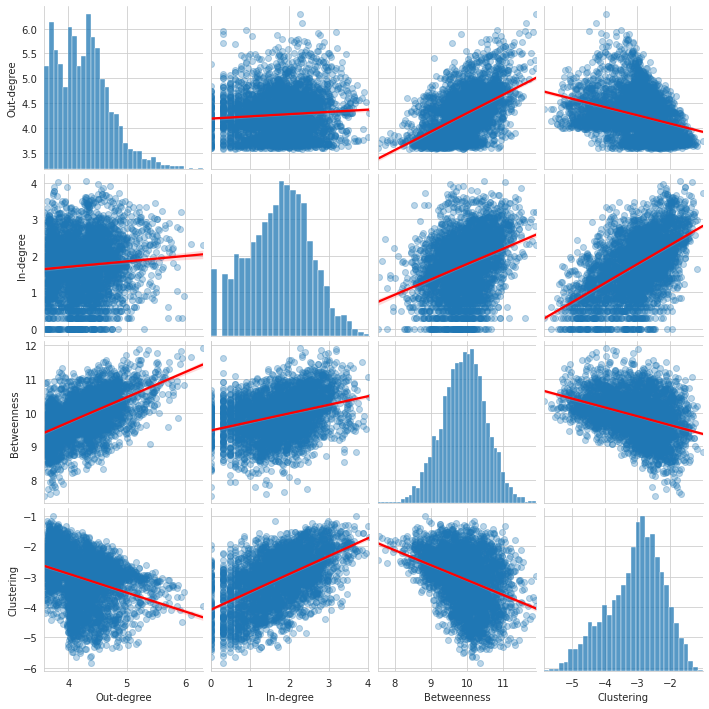

In [20]:
s_t=time.time()
f=plt.figure(dpi=300)
pplot=sns.pairplot(data=node_sample,kind='reg', 
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})
pplot.savefig('images/pplot_cent_top.png')
e_t=time.time()-s_t
print('Elapsed time: {} mins'.format(e_t/60))

Elapsed time: 0.08587353626887004 mins


<Figure size 1800x1200 with 0 Axes>

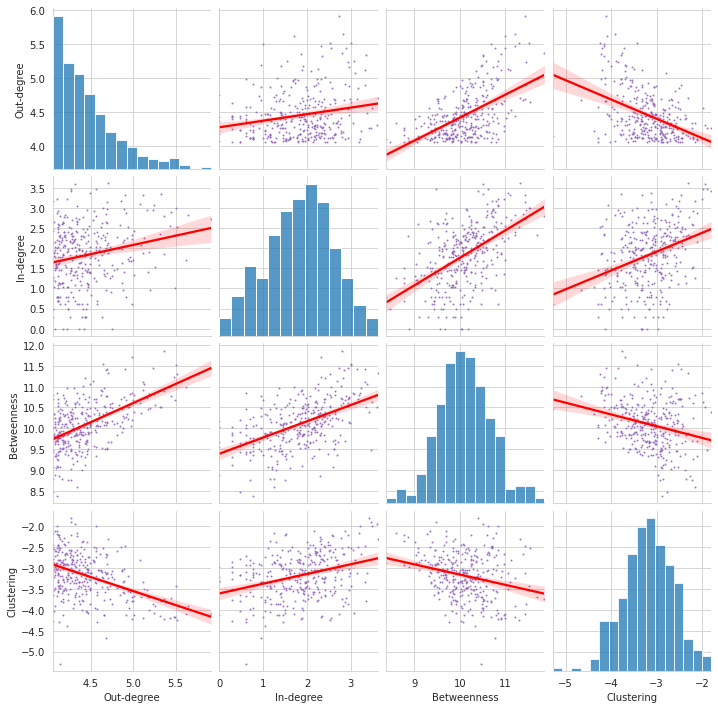

In [12]:
s_t=time.time()
f=plt.figure(dpi=300)
tipo='International expert'
pplot=sns.pairplot(data=node_sample[node_sample.Type==tipo],kind='reg', 
             plot_kws={'line_kws':{'color':'red'},
                       'scatter_kws': {'alpha': 0.8,'color':type2col[tipo],
                                      's':1}})
pplot.savefig('images/pplot_cent_top_'+tipo+'.png')
e_t=time.time()-s_t
print('Elapsed time: {} mins'.format(e_t/60))

Elapsed time: 0.8549822648366292 mins


<Figure size 1800x1200 with 0 Axes>

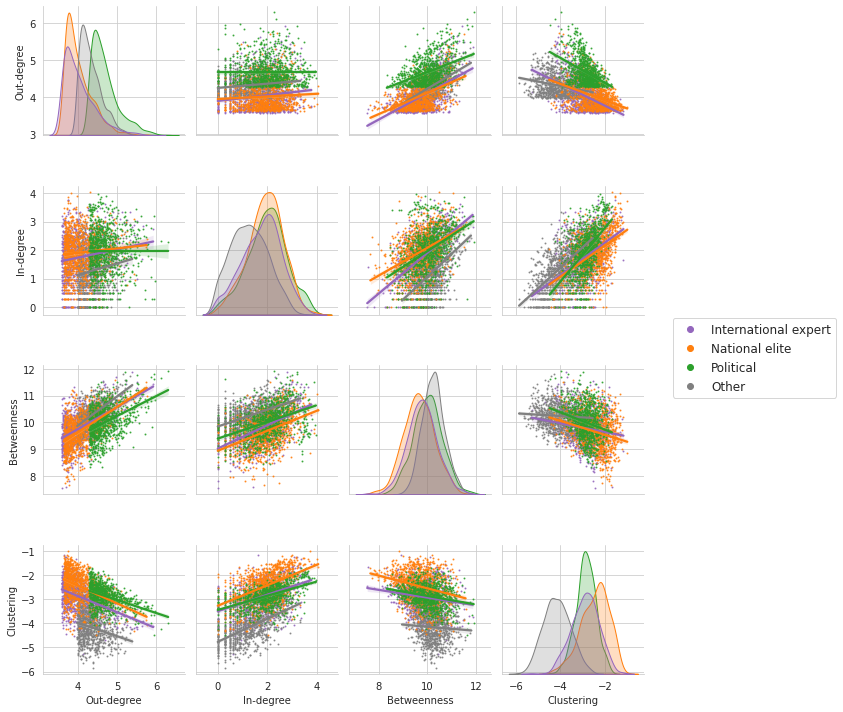

In [24]:
#SI Figure
s_t=time.time()
f=plt.figure(dpi=300)
node_sample['Super-community']=node_sample.index.map(com_of_user).map(com2type)

pplot=sns.pairplot(data=node_sample,hue='Super-community',kind='reg', 
             plot_kws={'scatter_kws': {'alpha': 0.8,'s':1}},
                       palette=type2col)
pplot._legend.remove()

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in type2col.values()]
plt.legend(markers, type2col.keys(), numpoints=1,loc=(1.2,.75),fontsize=12)
plt.tight_layout() 
plt.savefig('images/pdfs/pplot_cent_top4000.pdf',dpi=300)
e_t=time.time()-s_t
print('Elapsed time: {} mins'.format(e_t/60))